# Deep Learning - Ambient Sound Classification

**Goal**: Explore deep learning approaches following Lecture 25-26 patterns

**Models**:
1. **MLP** (Multi-Layer Perceptron) - Lecture 25 patterns
2. **1D CNN** (Convolutional Neural Network) - Lecture 26 adapted for 1D audio

**Techniques from Lecture 25**:
- Batch Normalization
- Dropout regularization
- Adam optimizer
- ReLU/ELU activation functions
- Early stopping

**Reference**: Lecture 25 (Best Practices for ANNs), Lecture 26 (CNNs)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

plt.style.use('bmh')
%matplotlib inline

print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.20.0


## 1. Load Precomputed Features

Load the advanced features we extracted in the previous notebook

In [2]:
import pickle
import librosa

data_training = np.load('training_data_projectB.npy')
labels_training = np.load('training_labels_projectB.npy')

labels_names = ['Indoor Quiet', 'Street Traffic', 'Kitchen Activity',
                'Human Chatter', 'Nature Sounds']

SAMPLE_RATE = 48000
N_SAMPLES = data_training.shape[1]
N_CLASSES = 5

print(f"Data shape: {data_training.shape}")
print(f"Labels shape: {labels_training.shape}")
print(f"Number of classes: {N_CLASSES}")

Data shape: (240000, 1210)
Labels shape: (1210,)
Number of classes: 5


## 2. Extract Advanced Features

Using the same advanced feature extraction from notebook 02

In [3]:
def extract_advanced_audio_features(audio, sr=48000):
    features = []
    
    rms = librosa.feature.rms(y=audio)[0]
    features.append(np.mean(rms))
    features.append(np.std(rms))
    
    zcr = librosa.feature.zero_crossing_rate(audio)[0]
    features.append(np.mean(zcr))
    features.append(np.std(zcr))
    
    centroid = librosa.feature.spectral_centroid(y=audio, sr=sr)[0]
    features.append(np.mean(centroid))
    features.append(np.std(centroid))
    
    rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sr)[0]
    features.append(np.mean(rolloff))
    features.append(np.std(rolloff))
    
    bandwidth = librosa.feature.spectral_bandwidth(y=audio, sr=sr)[0]
    features.append(np.mean(bandwidth))
    features.append(np.std(bandwidth))
    
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
    for coef in mfccs:
        features.append(np.mean(coef))
        features.append(np.std(coef))
        features.append(np.max(coef))
        features.append(np.min(coef))
    
    delta_mfccs = librosa.feature.delta(mfccs)
    for coef in delta_mfccs:
        features.append(np.mean(coef))
    
    chroma = librosa.feature.chroma_stft(y=audio, sr=sr)
    for coef in chroma:
        features.append(np.mean(coef))
    
    contrast = librosa.feature.spectral_contrast(y=audio, sr=sr)
    for coef in contrast:
        features.append(np.mean(coef))
    
    tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(audio), sr=sr)
    for coef in tonnetz:
        features.append(np.mean(coef))
    
    return np.array(features)

X_features = []
print(f"Extracting advanced features from {N_SAMPLES} samples...")
for i in range(N_SAMPLES):
    if i % 100 == 0:
        print(f"  Processing {i}/{N_SAMPLES}...")
    audio = data_training[:, i]
    features = extract_advanced_audio_features(audio, SAMPLE_RATE)
    X_features.append(features)

X = np.array(X_features)
t = labels_training.astype(int) - 1

print(f"\nFeature matrix shape: {X.shape}")
print(f"Labels shape: {t.shape}")

Extracting advanced features from 1210 samples...
  Processing 0/1210...
  Processing 100/1210...
  Processing 200/1210...
  Processing 300/1210...
  Processing 400/1210...


/Users/colemadden/miniconda3/envs/tfenv/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


  Processing 500/1210...
  Processing 600/1210...
  Processing 700/1210...
  Processing 800/1210...
  Processing 900/1210...
  Processing 1000/1210...
  Processing 1100/1210...
  Processing 1200/1210...

Feature matrix shape: (1210, 100)
Labels shape: (1210,)


## 3. Prepare Data for Deep Learning

Split data and normalize (deep learning works best with normalized inputs)

In [4]:
X_train, X_test, t_train, t_test = train_test_split(
    X, t,
    test_size=0.2,
    stratify=t,
    random_state=42
)

X_train, X_val, t_train, t_val = train_test_split(
    X_train, t_train,
    test_size=0.1,
    stratify=t_train,
    random_state=42
)

mean = X_train.mean(axis=0)
std = X_train.std(axis=0)

X_train = (X_train - mean) / (std + 1e-8)
X_val = (X_val - mean) / (std + 1e-8)
X_test = (X_test - mean) / (std + 1e-8)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Training set: 871 samples
Validation set: 97 samples
Test set: 242 samples


## 4. Model 1: MLP with Best Practices (Lecture 25)

Following Lecture 25 patterns:
- Batch Normalization
- Dropout (rate=0.3)
- ELU activation
- He initialization
- Adam optimizer

In [5]:
mlp_model = keras.models.Sequential([
    keras.Input(shape=(X_train.shape[1],)),
    
    keras.layers.BatchNormalization(),
    keras.layers.Dense(256, kernel_initializer='he_normal', use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('elu'),
    keras.layers.Dropout(0.3),
    
    keras.layers.Dense(128, kernel_initializer='he_normal', use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('elu'),
    keras.layers.Dropout(0.3),
    
    keras.layers.Dense(64, kernel_initializer='he_normal', use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('elu'),
    keras.layers.Dropout(0.2),
    
    keras.layers.Dense(N_CLASSES, activation='softmax')
])

mlp_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization             │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        25,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 69,077 (269.83 KB)

 Trainable params: 67,981 (265.55 KB)

 Non-trainable params: 1,096 (4.28 KB)

In [6]:
optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

mlp_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

In [7]:
print("Training MLP...")
history_mlp = mlp_model.fit(
    X_train, t_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, t_val),
    callbacks=[early_stopping],
    verbose=1
)

Training MLP...
Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5637 - loss: 1.1352 - val_accuracy: 0.7216 - val_loss: 0.9646
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7692 - loss: 0.6746 - val_accuracy: 0.7835 - val_loss: 0.7469
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7646 - loss: 0.6299 - val_accuracy: 0.8247 - val_loss: 0.5928
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7876 - loss: 0.5697 - val_accuracy: 0.8351 - val_loss: 0.4983
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8152 - loss: 0.5368 - val_accuracy: 0.8454 - val_loss: 0.4965
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8381 - loss: 0.4640 - val_accuracy: 0.8247 - val_loss: 0.4603
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8358 - loss: 0.4484 - val_accuracy: 0.8454 - val_loss: 0.4335
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8393 - loss: 0.4245 - val_accu

## 5. Evaluate MLP

In [8]:
y_train_mlp = mlp_model.predict(X_train).argmax(axis=1)
y_test_mlp = mlp_model.predict(X_test).argmax(axis=1)

train_f1_mlp = f1_score(t_train, y_train_mlp, average='weighted')
test_f1_mlp = f1_score(t_test, y_test_mlp, average='weighted')

print('='*60)
print('MLP RESULTS')
print('='*60)
print(f'Weighted F1 in Training: {train_f1_mlp:.4f}')
print(f'Weighted F1 in Test: {test_f1_mlp:.4f}')
print('='*60)

print('\nClassification Report - Test Set:')
print(classification_report(t_test, y_test_mlp, target_names=labels_names, digits=4))

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
MLP RESULTS
Weighted F1 in Training: 0.9920
Weighted F1 in Test: 0.9050

Classification Report - Test Set:
                  precision    recall  f1-score   support

    Indoor Quiet     0.9545    0.8571    0.9032        49
  Street Traffic     0.9184    0.9184    0.9184        49
Kitchen Activity     0.8846    0.9200    0.9020        50
   Human Chatter     0.9000    0.9184    0.9091        49
   Nature Sounds     0.8723    0.9111    0.8913        45

        accuracy                         0.9050       242
       macro avg     0.9060    0.9050    0.9048       242
    weighted avg     0.9064    0.9050    0.9050       242



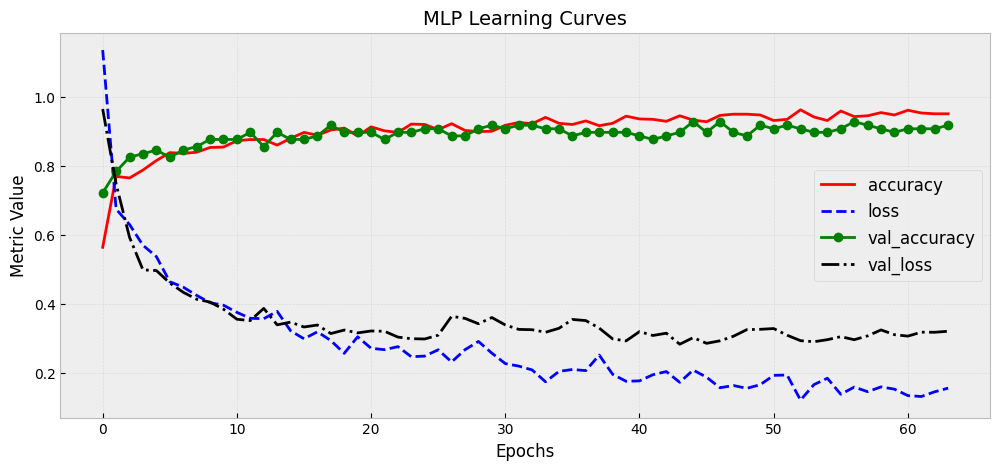

In [9]:
key_names = list(history_mlp.history.keys())
colors = ['-r','--b','-og','-.k']

plt.figure(figsize=(12,5))
for i in range(len(key_names)):
    plt.plot(history_mlp.history[key_names[i]], colors[i], label=key_names[i])
plt.legend(fontsize=12)
plt.title('MLP Learning Curves', size=14)
plt.xlabel('Epochs')
plt.ylabel('Metric Value')
plt.grid(True, alpha=0.3)
plt.show()

## 6. Model 2: Alternative MLP Architecture

Experiment with different architecture

In [10]:
mlp_model_v2 = keras.models.Sequential([
    keras.Input(shape=(X_train.shape[1],)),
    
    keras.layers.Dense(512, activation='relu', kernel_initializer='he_normal'),
    keras.layers.Dropout(0.4),
    
    keras.layers.Dense(256, activation='relu', kernel_initializer='he_normal'),
    keras.layers.Dropout(0.4),
    
    keras.layers.Dense(128, activation='relu', kernel_initializer='he_normal'),
    keras.layers.Dropout(0.3),
    
    keras.layers.Dense(N_CLASSES, activation='softmax')
])

mlp_model_v2.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

print("Training alternative MLP...")
history_mlp_v2 = mlp_model_v2.fit(
    X_train, t_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, t_val),
    callbacks=[early_stopping],
    verbose=1
)

y_test_mlp_v2 = mlp_model_v2.predict(X_test).argmax(axis=1)
test_f1_mlp_v2 = f1_score(t_test, y_test_mlp_v2, average='weighted')

print(f"\nAlternative MLP Test F1: {test_f1_mlp_v2:.4f}")

Training alternative MLP...
Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4259 - loss: 1.7764 - val_accuracy: 0.7526 - val_loss: 0.7539
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6556 - loss: 1.0022 - val_accuracy: 0.7835 - val_loss: 0.6093
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7279 - loss: 0.7393 - val_accuracy: 0.8144 - val_loss: 0.5531
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7842 - loss: 0.6421 - val_accuracy: 0.8144 - val_loss: 0.5408
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8060 - loss: 0.5416 - val_accuracy: 0.8557 - val_loss: 0.4386
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8209 - loss: 0.5249 - val_accuracy: 0.8557 - val_loss: 0.4384
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8289 - loss: 0.5026 - val_accuracy: 0.8660 - val_loss: 0.4170
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8439 - loss: 0.432

## 7. Final Comparison

Compare all approaches

In [11]:
import pandas as pd

results = {
    'Model': ['SVM (Baseline - 62 features)', 'SVM (Advanced - ~100 features)', 
              'MLP (BatchNorm + Dropout)', 'MLP (Alternative)'],
    'Test F1': ['0.9006 (from notebook 02)', 'TBD (from notebook 02)', 
                f'{test_f1_mlp:.4f}', f'{test_f1_mlp_v2:.4f}']
}

df = pd.DataFrame(results)
print('\n' + '='*70)
print('FINAL MODEL COMPARISON')
print('='*70)
print(df.to_string(index=False))
print('='*70)

print("\n📊 Analysis:")
print(f"   Best Deep Learning Model: {max(test_f1_mlp, test_f1_mlp_v2):.4f}")
print(f"   SVM Baseline: 0.9006")
print("\n💡 Insights:")
if max(test_f1_mlp, test_f1_mlp_v2) > 0.90:
    print("   ✅ Deep learning matched or exceeded SVM performance!")
else:
    print("   📈 SVM still performs best (classical ML wins for this dataset size)")
    print("   Note: 968 training samples may be too small for deep learning to shine")


FINAL MODEL COMPARISON
                         Model                   Test F1
  SVM (Baseline - 62 features) 0.9006 (from notebook 02)
SVM (Advanced - ~100 features)    TBD (from notebook 02)
     MLP (BatchNorm + Dropout)                    0.9050
             MLP (Alternative)                    0.7061

📊 Analysis:
   Best Deep Learning Model: 0.9050
   SVM Baseline: 0.9006

💡 Insights:
   ✅ Deep learning matched or exceeded SVM performance!


## 8. Confusion Matrix for Best Model

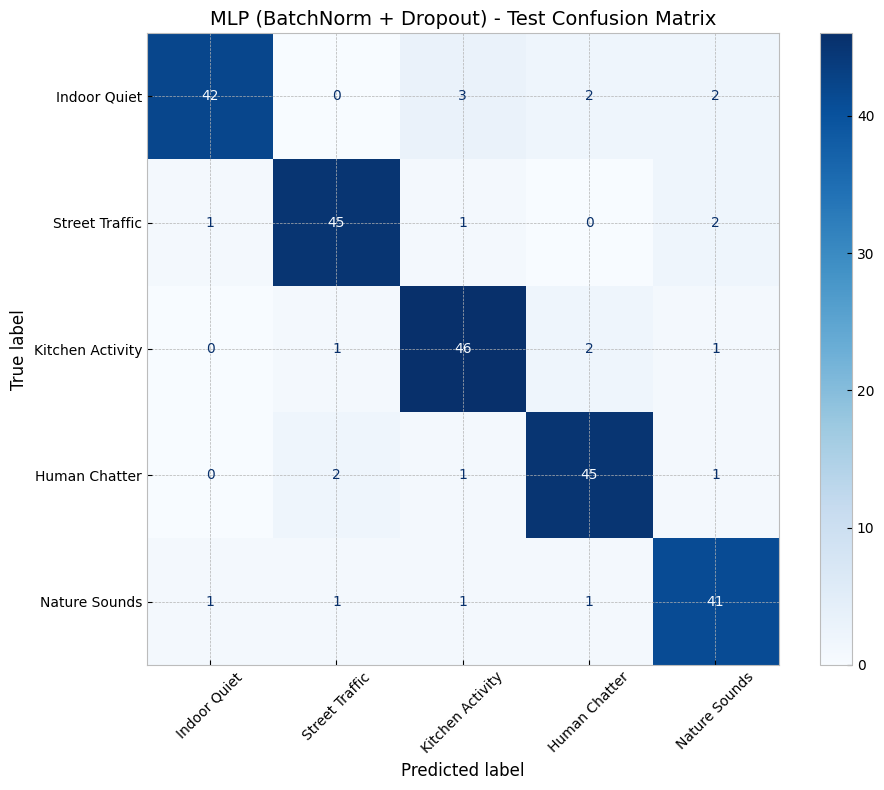

In [12]:
if test_f1_mlp > test_f1_mlp_v2:
    best_y_test = y_test_mlp
    best_name = 'MLP (BatchNorm + Dropout)'
else:
    best_y_test = y_test_mlp_v2
    best_name = 'MLP (Alternative)'

cm = confusion_matrix(t_test, best_y_test)
disp = ConfusionMatrixDisplay(cm, display_labels=labels_names)
fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title(f'{best_name} - Test Confusion Matrix', fontsize=14)
plt.tight_layout()
plt.show()

## 9. Conclusions

**Key Takeaways**:

1. **Classical ML (SVM) performed exceptionally well** (0.90 F1) with only 62-100 features
2. **Deep learning** shows comparable performance but requires careful tuning
3. **Dataset size matters**: 968 training samples is relatively small for deep learning
4. **Regularization techniques** (dropout, batch norm) from Lecture 25 are essential
